In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score

# Merge results

In [2]:
results = pd.read_csv("data/processed/test.csv")

In [3]:
RoBERTa_base = pd.read_csv("output/RoBERTa_base.csv")
results = pd.merge(results, RoBERTa_base, on = 'review_id')

In [ ]:
RoBERTa_ft = pd.read_csv("output/RoBERTa_ft_cls.csv")
results = pd.merge(results, RoBERTa_ft, on = 'review_id')

In [4]:
SiEBERT = pd.read_csv("output/SiEBERT.csv")
results = pd.merge(results, SiEBERT, on = 'review_id')

In [ ]:
GPT = pd.read_csv("output/GPT.csv")
results = pd.merge(results, GPT, on = 'review_id')

# Compare performances

In [5]:
models = ["RoBERTa_base", "SiEBERT"]

## Average

In [6]:
accuracies = {model: accuracy_score(results["sentiment"], results[model]) for model in models}
accuracy_avg = pd.DataFrame(accuracies.items(), columns=["Model", "Accuracy"])
accuracy_avg.style.hide(axis="index")

Model,Accuracy
RoBERTa_base,0.917080
SiEBERT,0.957320


## By ratings / sentiments

In [7]:
accuracy_rtg = (
    results.groupby("rating")
    .apply(lambda group: {model: accuracy_score(group["sentiment"], group[model]) for model in models}, include_groups = False)
    .apply(pd.Series)
).sort_values("rating").reset_index()
accuracy_rtg.style.hide(axis="index")

rating,RoBERTa_base,SiEBERT
1,0.949821,0.984269
2,0.907906,0.976977
3,0.838253,0.944510
4,0.720304,0.875901
7,0.921977,0.899870
8,0.964912,0.966316
9,0.973123,0.979096
10,0.976395,0.981796


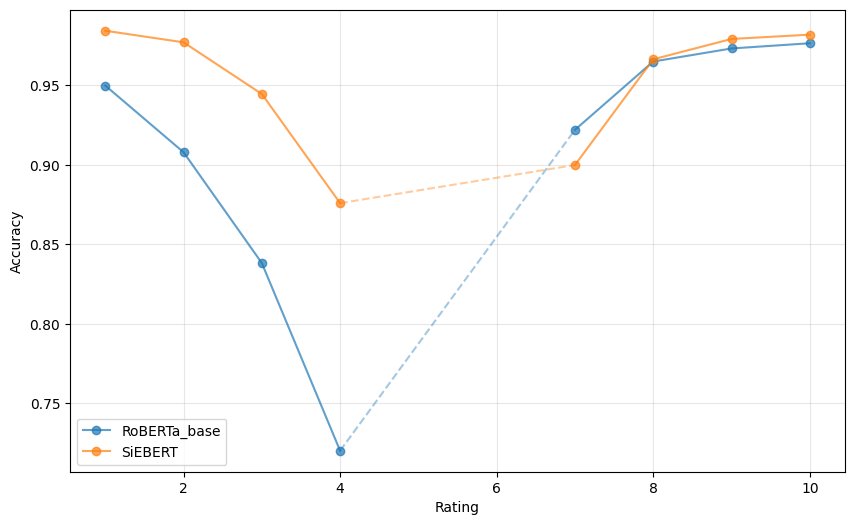

In [8]:
accuracy_long = accuracy_rtg.melt(id_vars="rating", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(10, 6))

# Define a color map for the models
colors = {
    model: plt.cm.tab10(i) for i, model in enumerate(accuracy_long["Model"].unique())
}

# Group by model and plot each group separately
for model in accuracy_long["Model"].unique():
    model_data = accuracy_long[accuracy_long["Model"] == model]
    color = colors[model]
    
    # Split the data into two segments: ratings 1-4 and 7-10
    lower_ratings = model_data[model_data["rating"] <= 4]
    higher_ratings = model_data[model_data["rating"] >= 7]
    
    # Plot each segment with the same color
    plt.plot(lower_ratings["rating"], lower_ratings["Accuracy"], marker="o", linestyle="-", 
             color=color, alpha=0.7, label=model if len(lower_ratings) > 0 else None)
    plt.plot(higher_ratings["rating"], higher_ratings["Accuracy"], marker="o", linestyle="-", 
             color=color, alpha=0.7, label=None)
    
    # Connect the two segments with a styled line to indicate discontinuity if both segments exist
    if len(lower_ratings) > 0 and len(higher_ratings) > 0:
        plt.plot([lower_ratings["rating"].iloc[-1], higher_ratings["rating"].iloc[0]], 
                 [lower_ratings["Accuracy"].iloc[-1], higher_ratings["Accuracy"].iloc[0]], 
                 linestyle="--", alpha=0.4, color=color)

# Add a single legend entry for each model
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("Rating")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

plt.savefig("output/accuracy_vs_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

## By review length

In [18]:
results['nb_words'] = results['text'].apply(lambda x: len(x.split()))

bins = pd.qcut(results["nb_words"], q=15, duplicates="drop")
upper_bounds = np.array([interval.right for interval in bins.cat.categories])
results["max_words"] = upper_bounds[bins.cat.codes]

In [19]:
accuracy_lth = (
    results.groupby("max_words")
    .apply(lambda group: {model: accuracy_score(group["sentiment"], group[model]) for model in models}, include_groups = False)
    .apply(pd.Series)
).reset_index()
accuracy_lth.style.hide(axis="index")

max_words,RoBERTa_base,SiEBERT
70.000000,0.924251,0.951262
102.000000,0.927853,0.958604
117.000000,0.918052,0.956057
127.000000,0.925837,0.965311
137.000000,0.932441,0.958004
149.000000,0.917205,0.958896
163.000000,0.923641,0.960904
180.000000,0.920728,0.960658
200.000000,0.915275,0.956710
226.000000,0.919423,0.953097


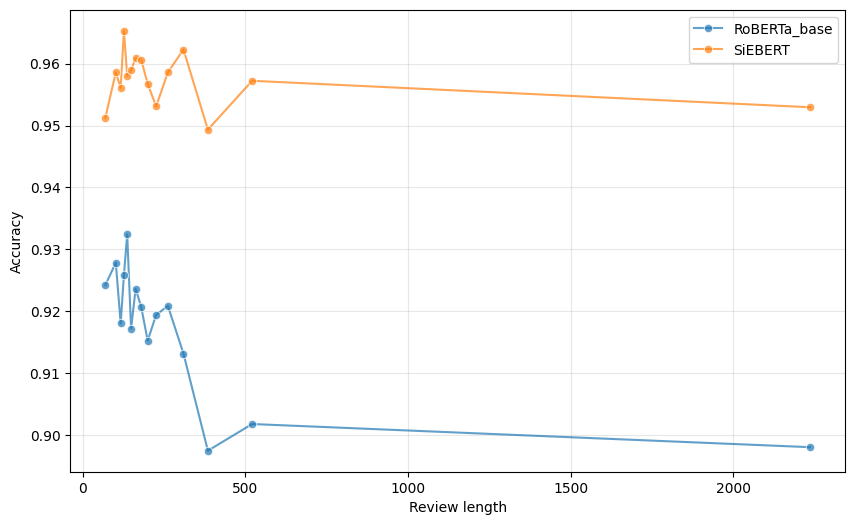

In [20]:
accuracy_long = accuracy_lth.melt(id_vars="max_words", var_name="Model", value_name="Accuracy")
accuracy_long["max_words"] = accuracy_long["max_words"].astype(float)
accuracy_long = accuracy_long.sort_values("max_words")

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracy_long, x="max_words", y="Accuracy", hue="Model", marker="o", alpha=0.7)
plt.xlabel("Review length")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("output/accuracy_vs_wordcount.png", dpi=300, bbox_inches='tight')
plt.show()